# ASTR 596: FDS - The Midterm

### Dun, dun dun. 
#### (suspenseful music here)

## Start with the Cepheid data you have already seen in lecture 03 and 04.

## There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

## Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file.

In [3]:
exec(open('cepheids.py').read())
ceph = Cepheids('../../data/03/R11ceph.dat')
hosts = ceph.list_hosts()

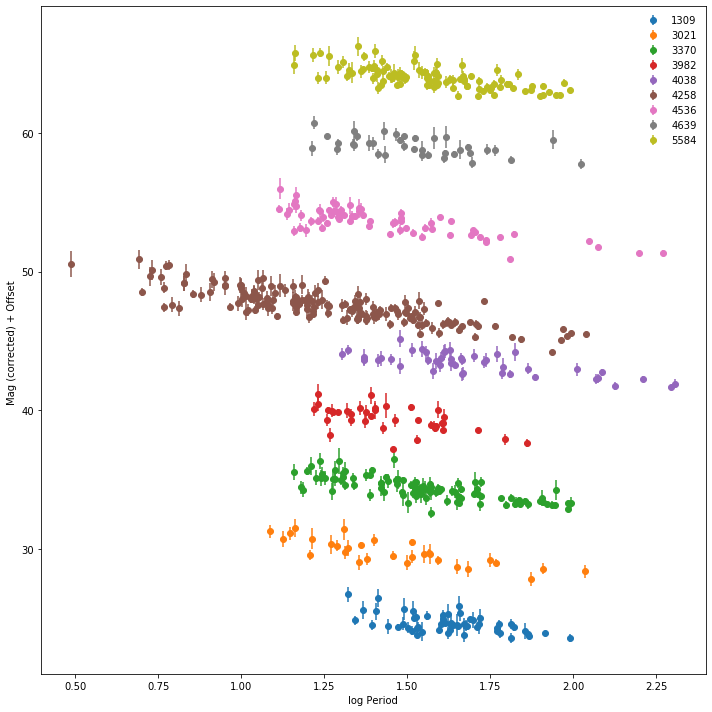

In [4]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


The answer is given in the code in `cepheids.py`.

$$ \chi^2_{i,j} = \sum_{i,j} \left( \frac{m_{\text{obs},i,j} - a_i \log{P_{i,j}} - b_i }{ \sigma_{{\rm int},i} } \right)^2 $$

The negative log likelihood is then:

$$ -\log{L}_{i,j} = 0.5 \chi^2_{i,j} $$

$$ \boxed{ -\log{L}_{i,j} = 0.5 \sum_{i,j} \left( \frac{m_{\text{obs},i,j} - a_i \log{P_{i,j}} - b_i }{ \sigma_{{\rm int},i} } \right)^2 } $$

where, ignoring metallicity the model parameters are:

$$a_i = b_W $$
$$ b_i = (\mu_{0,i}-\mu_{0,4258}) + zp_{W,4258} .$$


# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

We know the distance must be positive and the slope negative. More realistically, this means the y-intercept is $25<b_i<30$ and slope of $-20<a_i<0$ looking at the data by eye.

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

100%|██████████| 10000/10000 [00:22<00:00, 438.54it/s]


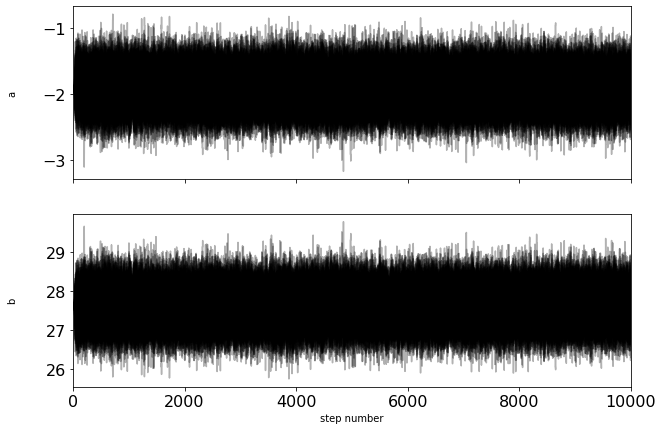

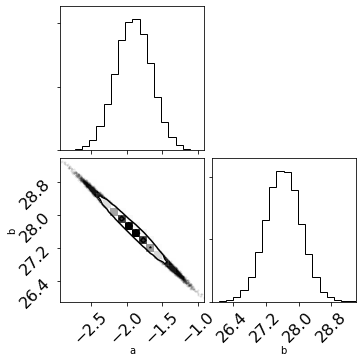

1309


<IPython.core.display.Math object>

<IPython.core.display.Math object>

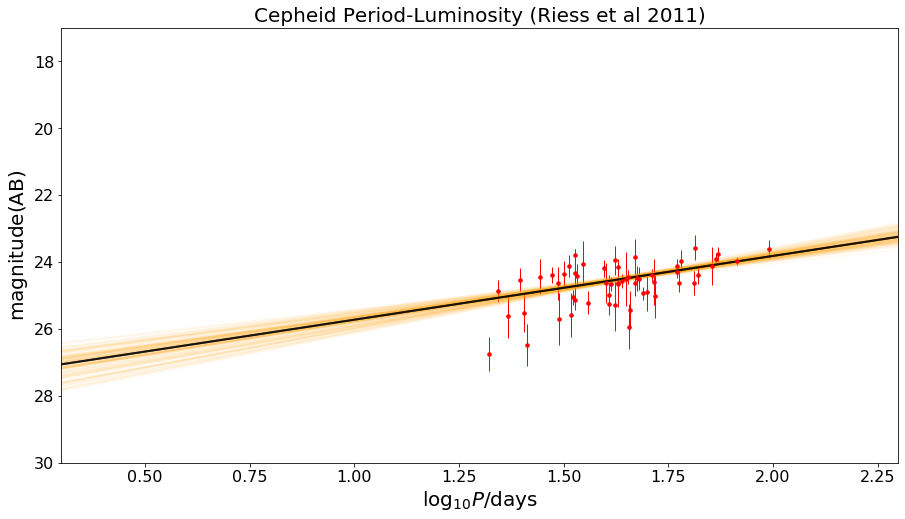

100%|██████████| 10000/10000 [00:22<00:00, 445.16it/s]


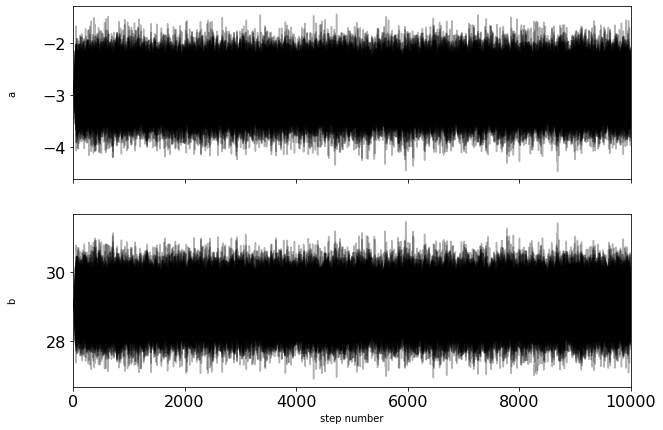

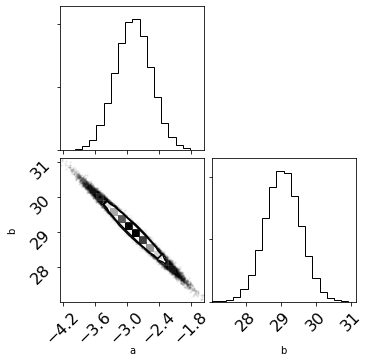

3021


<IPython.core.display.Math object>

<IPython.core.display.Math object>

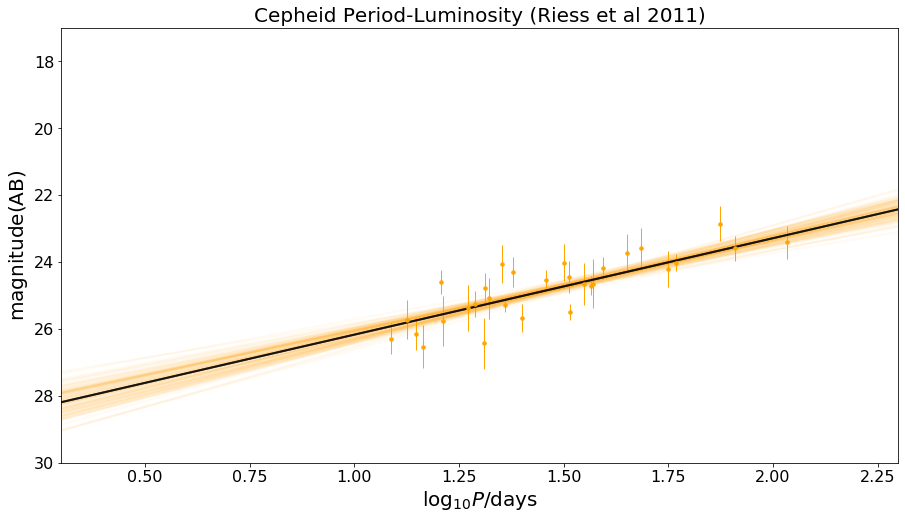

100%|██████████| 10000/10000 [00:24<00:00, 411.42it/s]


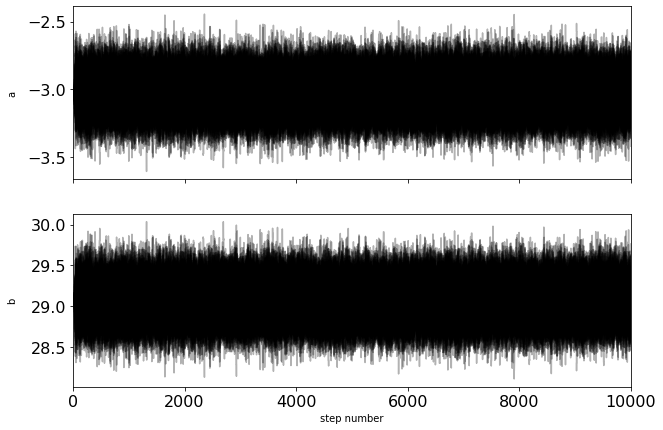

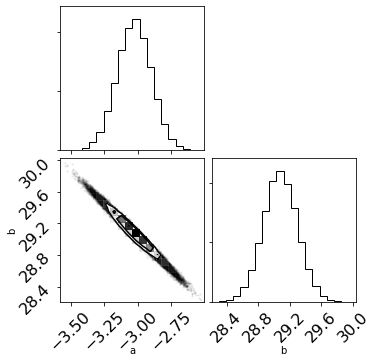

3370


<IPython.core.display.Math object>

<IPython.core.display.Math object>

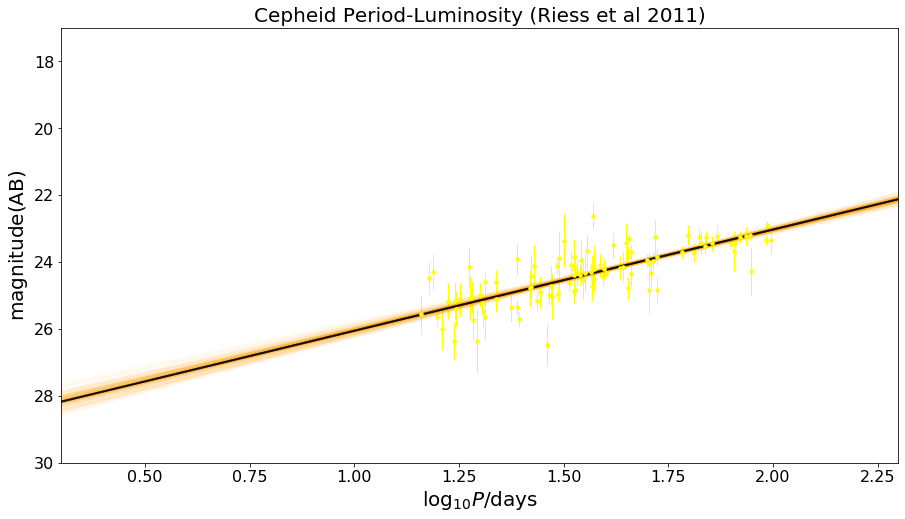

100%|██████████| 10000/10000 [00:23<00:00, 419.76it/s]


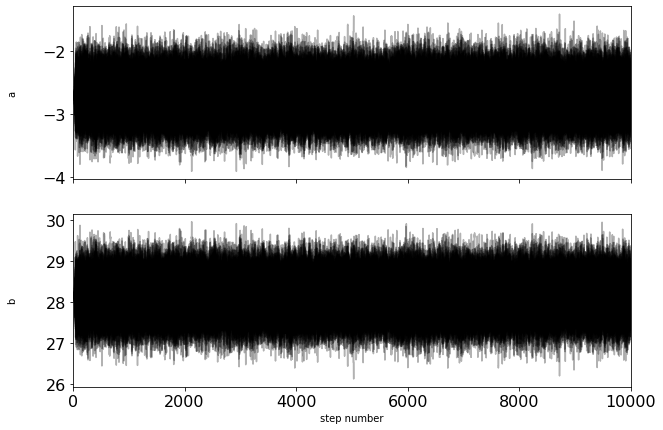

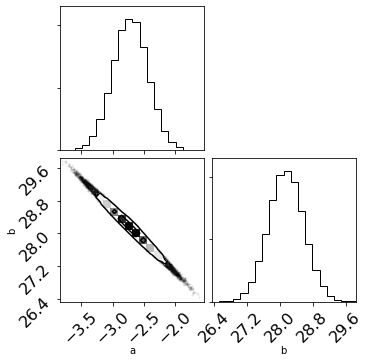

3982


<IPython.core.display.Math object>

<IPython.core.display.Math object>

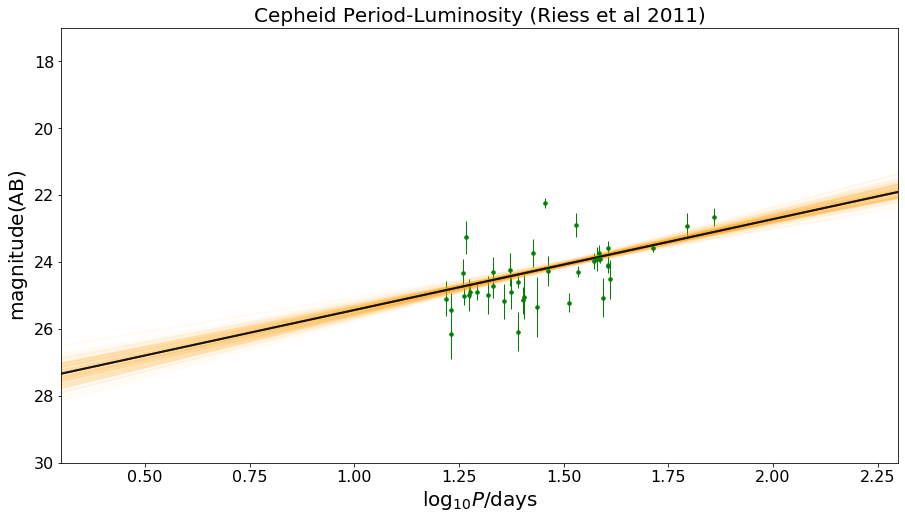

100%|██████████| 10000/10000 [00:23<00:00, 418.20it/s]


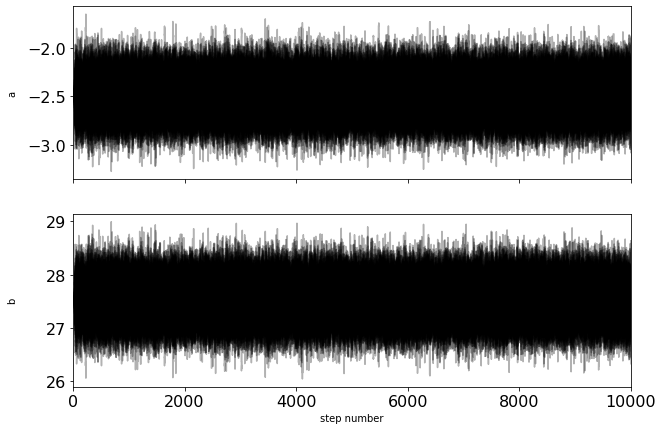

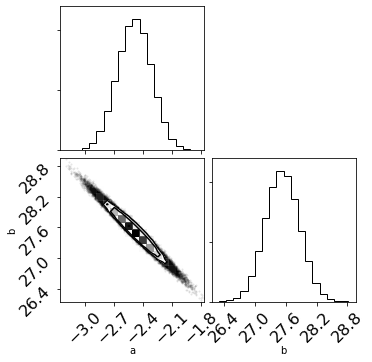

4038


<IPython.core.display.Math object>

<IPython.core.display.Math object>

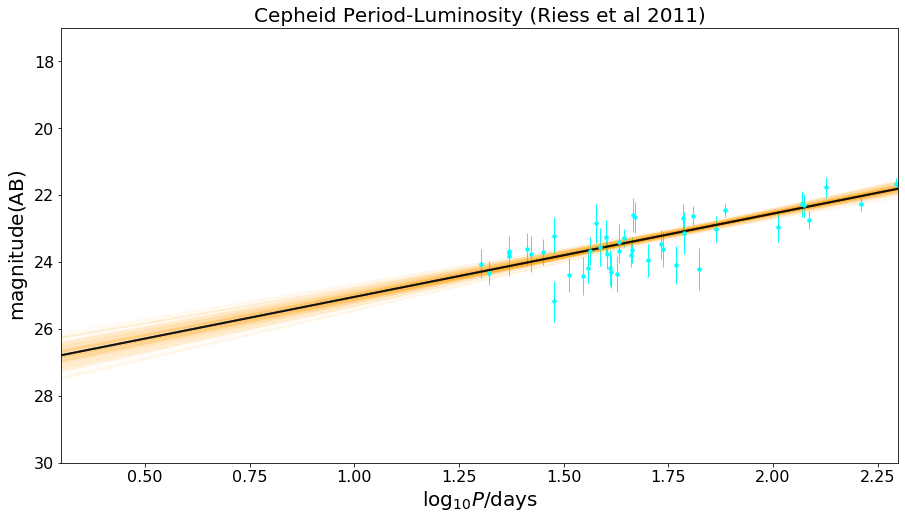

100%|██████████| 10000/10000 [00:24<00:00, 408.01it/s]


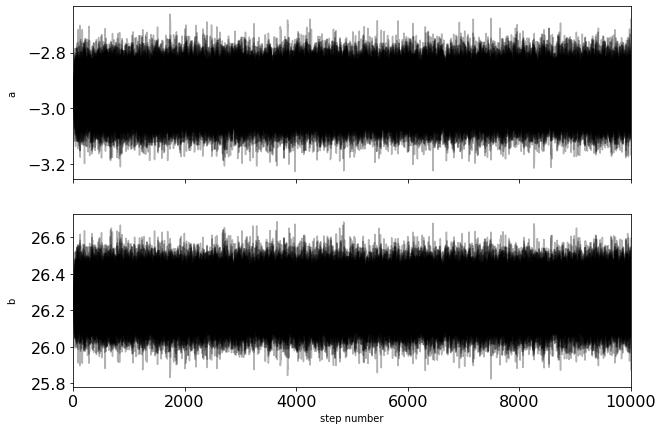

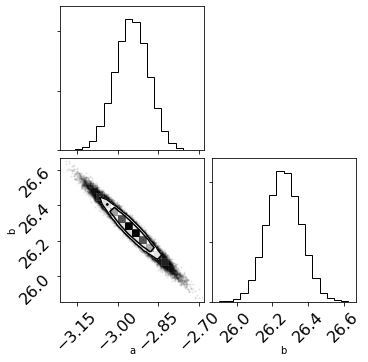

4258


<IPython.core.display.Math object>

<IPython.core.display.Math object>

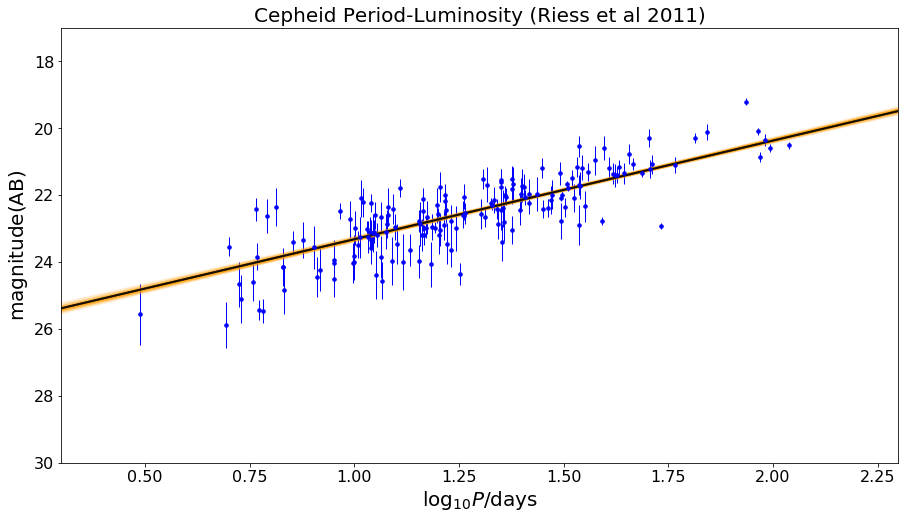

100%|██████████| 10000/10000 [00:21<00:00, 459.45it/s]


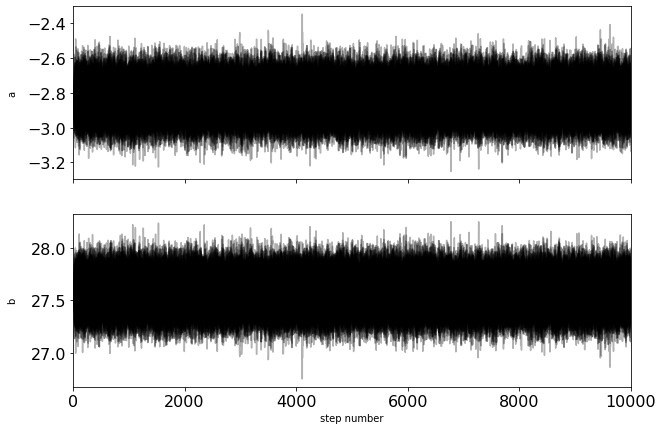

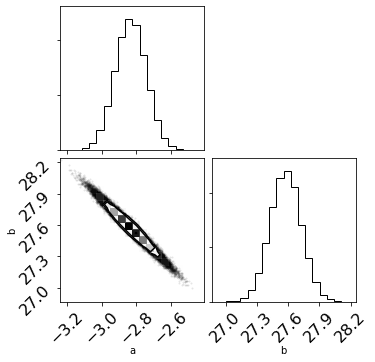

4536


<IPython.core.display.Math object>

<IPython.core.display.Math object>

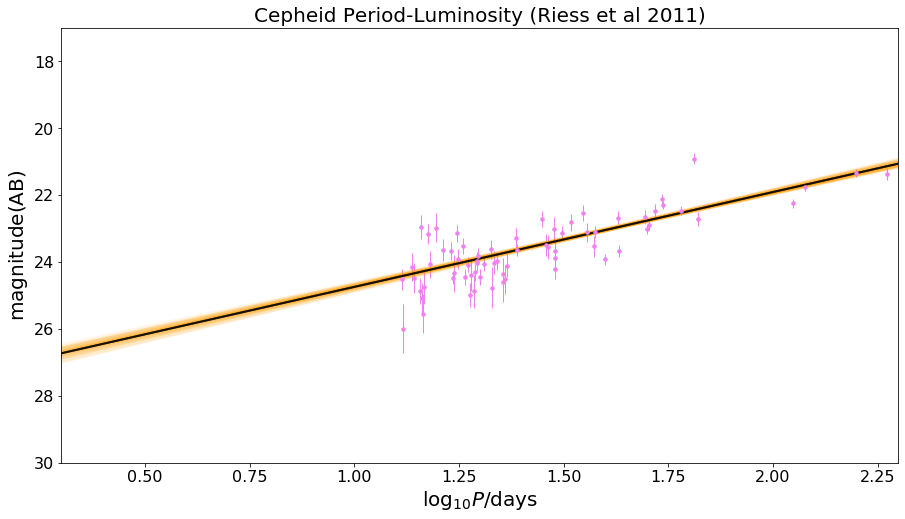

100%|██████████| 10000/10000 [00:23<00:00, 422.79it/s]


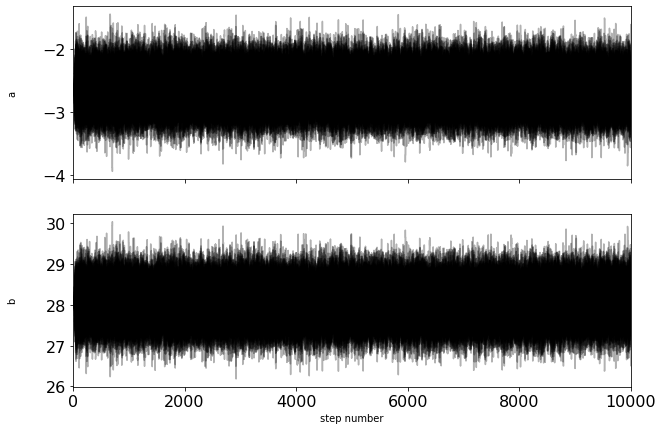

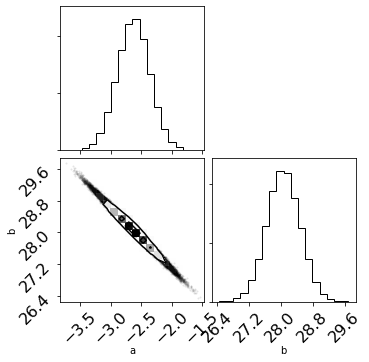

4639


<IPython.core.display.Math object>

<IPython.core.display.Math object>

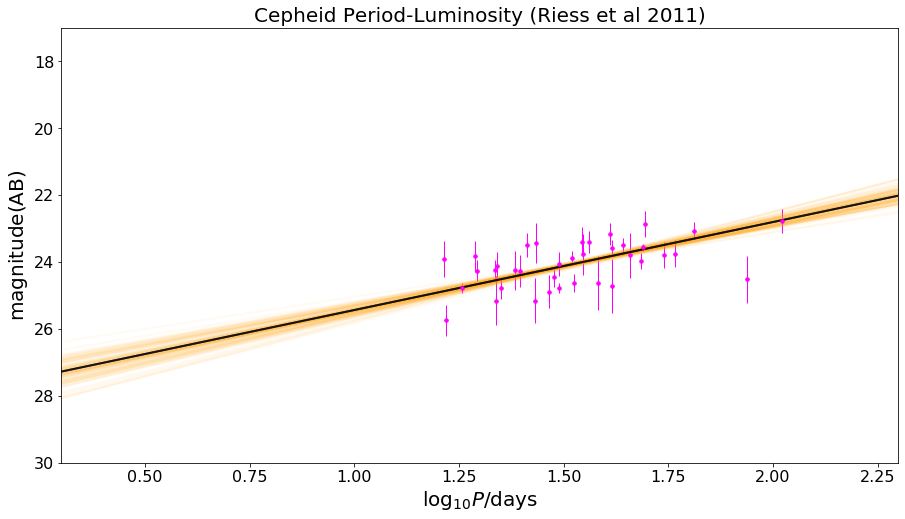

100%|██████████| 10000/10000 [00:23<00:00, 427.65it/s]


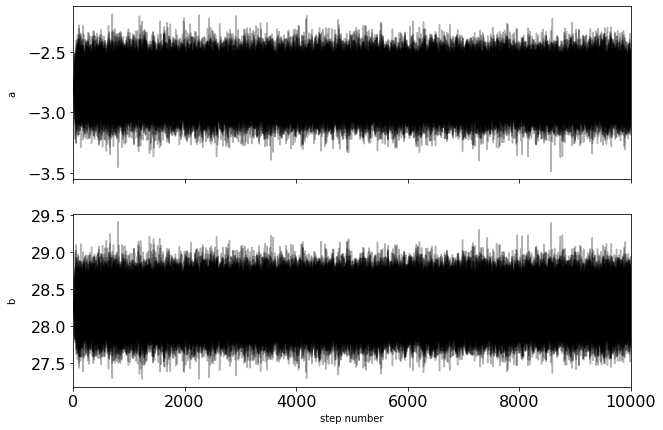

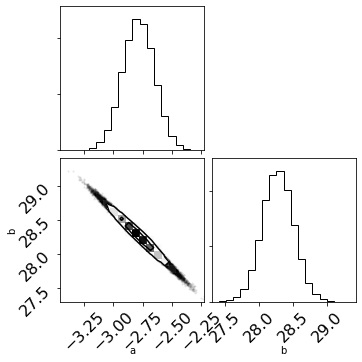

5584


<IPython.core.display.Math object>

<IPython.core.display.Math object>

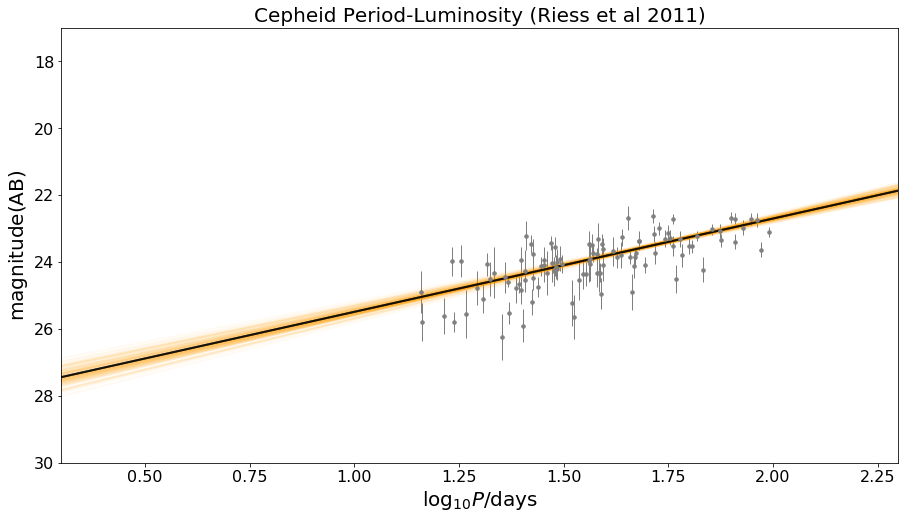

In [57]:
import numpy as np
import emcee
import corner
from scipy.optimize import minimize
from IPython.display import display, Math

# shape and number of walkers
ndim, nwalkers = 2, 100

b_i_arr = []


# log prior function
def log_prior(theta):
    a, b = theta[0], theta[1]
    if -10.0 < a < 0 and 25.0 < b < 35.0:
        return 0.0
    return -np.inf

# loop through hosts
for i, ID in enumerate(hosts):
    ceph.select(ID)
    
    # log prob function
    def log_probability(theta):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp - ceph.negative_log_likelihood(theta)
    
    # initialize
    initial = np.array([-2, 27])
    soln = minimize(ceph.negative_log_likelihood, initial)
    a_ml, b_ml = soln.x
    
    # emcee init
    pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)

    # sample
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
    sampler.run_mcmc(pos, 10000, progress=True)
    
    # get final samples
    samples = sampler.get_chain()
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    
    # plot chains
    fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
    labels = ["a", "b"]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    plt.show()
    
    # plot corner
    fig = corner.corner(flat_samples, labels=labels)
    plt.show()
    
    print(ID)
    
    # print fit and uncertainty
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))
        if i == 0: # a
            a_fit = mcmc[1]
        elif i == 1: # b
            b_fit = mcmc[1]
    
    # plot fit
    ceph.plot(ID)
    inds = np.random.randint(len(flat_samples), size=100)
    for ind in inds:
        sample = flat_samples[ind]
        ceph.overlay_straight_line_with(sample[0], sample[1], alpha=0.05, color='orange')
    ceph.overlay_straight_line_with(a_fit, b_fit, label='fit')
    ceph.overlay_straight_line_with(a_fit, b_fit, label='fit')
    plt.show()
    
    if int(ID) != 4258: # don't use 4258 (this is the first step in the ladder)
        b_i_arr.append(b_fit)
    

Comparing to Fig. 7, the fits look reasonable.

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

$$ \log H_0 = \frac{(m^0_{v,4285}-\mu_{0,4258}) + 5a_v + 25}{5}$$

Substituting from Eq. 3: $ m^0_{v,4285} - \mu_{0,4258} = m_{v,i}^0 - \mu_{0,i}$

$$ \log H_0 = \frac{( m_{v,i}^0 - \mu_{0,i}) + 5a_v + 25}{5}$$

where: $ b_i = (\mu_{0,i}-\mu_{0,4258}) + zp_{W,4258} $:

or: $ \mu_{0,i} = \mu_{0,4258} +b_i - zp_{W,4258} $.

Therefore,

$$ \boxed{ \log H_0 = \frac{( m_{v,i}^0  - \mu_{0,4258} - b_i + zp_{W,4258}) + 5a_v + 25}{5} }$$


# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [73]:
dtype={'names': ('host', 'sn', 'filters','m0vi+5av','sigmaa'),
    'formats': ('S4', 'S8', 'S5', 'f4', 'f4')}
# NOTE: I ordered them properly by hand in the table3.dat file (I'm lazy, what can I say)
dat = np.loadtxt('../../data/03/table3.dat',dtype=dtype)

m0vi_plus_5av = dat['m0vi+5av']

zpW4258 = 26.264 # from before

# order by

d04258 = 7.60*1e6 # pc
mu04258 = 5*np.log10(d04258) - 5

# take the mean of all the measurements:
# use the std to estimate the error

logH0 = (m0vi_plus_5av - mu04258 - b_i_arr + zpW4258 + 25)/5
H0 = 10**logH0

H0_mean = np.mean(H0)
H0_err = np.std(H0)
         
txt = "H_0 = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
txt = txt.format(H0_mean, H0_err, H0_err)
display(Math(txt))

<IPython.core.display.Math object>